In [79]:
import os
from typing import Iterator, MutableSequence, Optional, Sequence, Tuple, List
from tabulate import tabulate

In [58]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv

In [7]:
from google.api_core.client_options import ClientOptions
from google.cloud import documentai_v1

In [3]:
PROJECT_ID = os.getenv("PROJECT_ID", "")
API_LOCATION = os.getenv("API_LOCATION", "")

In [6]:
indic_parser_name = "indic_test_processor"

In [8]:
opts = ClientOptions(api_endpoint=f"{API_LOCATION}-documentai.googleapis.com")

In [9]:
client = documentai_v1.DocumentProcessorServiceClient(client_options=opts)

In [10]:
full_processor_name = client.processor_path(PROJECT_ID, API_LOCATION, "5945bfe7932ca5b7")

In [11]:
request = documentai_v1.GetProcessorRequest(name=full_processor_name)
processor = client.get_processor(request=request)

In [12]:
processor.name

'projects/781576483146/locations/us/processors/5945bfe7932ca5b7'

In [23]:
file_path = "/Users/niteshkumarsharma/Desktop/Folder/AI/indic_document_extraction/sample_images/hindi/textbook_digital_hindi_03.png"

In [24]:
# Read the file into memory.
with open(file_path, "rb") as image:
    image_content = image.read()

In [25]:
raw_document = documentai_v1.RawDocument(
    content=image_content,
    mime_type="image/png",
)

In [26]:
request = documentai_v1.ProcessRequest(name=processor.name, raw_document=raw_document)
result = client.process_document(request=request)
document = result.document

In [ ]:
def visualize_document_bounds(image_path: str, document: documentai_v1.Document):
    """
    Draws bounding boxes from a Document AI result onto the original image.

    Args:
        image_path: The path to the original image file.
        document: The Document object returned by the Document AI API.
    """
    print("Opening original image to draw bounding boxes...")
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    width, height = image.size

    print(f"Found {len(document.pages)} page(s) in the document.")

    for page in document.pages:
        # --- Option A: Draw Bounding Boxes for every detected LINE ---
        print(f"Drawing {len(page.lines)} lines...")
        for line in page.lines:
            # The bounding box is a polygon, so we need to draw it as such
            polygon = [
                (vertex.x * width, vertex.y * height)
                for vertex in line.layout.bounding_poly.normalized_vertices
            ]
            draw.polygon(polygon, outline="blue", width=2)
            
        # --- Option B: Draw Bounding Boxes for FORM FIELDS (if using a form parser) ---
        print(f"Drawing {len(page.form_fields)} form fields...")
        for field in page.form_fields:
            # Draw the key
            key_polygon = [
                (vertex.x * width, vertex.y * height)
                for vertex in field.field_name.layout.bounding_poly.normalized_vertices
            ]
            draw.polygon(key_polygon, outline="red", width=3)
            # Draw the value
            value_polygon = [
                (vertex.x * width, vertex.y * height)
                for vertex in field.field_value.layout.bounding_poly.normalized_vertices
            ]
            draw.polygon(value_polygon, outline="green", width=3)

    # --- Option C: Draw Bounding Boxes for ENTITIES (if using a specialized parser) ---
    print(f"Drawing {len(document.entities)} entities...")
    for entity in document.entities:
        # Entities can span multiple pages, so we need to iterate through page anchors
        for page_anchor in entity.page_anchor.page_refs:
            polygon = [
                (vertex.x * width, vertex.y * height)
                for vertex in page_anchor.bounding_poly.normalized_vertices
            ]
            draw.polygon(polygon, outline="purple", width=4)
            # You can also draw the entity type on the image
            # draw.text((polygon[0][0], polygon[0][1] - 10), entity.type_, fill="purple")

    return image

uri: ""
mime_type: "image/png"
text: "मात्रक एवं मापन\n3\nनाम\nप्रतीक\nमिनट\nmin\nघंटा\nh\nदिन\nd\nवर्ष\ny\nसारणी 1.2 सामान्य प्रयोग के लिए SI मात्रकों के अतिरिक्त कुछ अन्य मात्रक\nSI मात्रक के पदों में मान\n60 s\n60 min = 3600 s\n24 h = 86400 s\n365.25 d 3.156 × 107 s\nडिग्री\n1° = (π/180) rad\nलिटर\nटन\nकैरट\nबार\nL\n1 dm³ = 10-³ m³\nt\n103 kg\nC\nbar\nक्यूरी\nCi\nरोंजन\nR\nक्विंटल\nq\nबार्न\nb\nआर\na\nहेक्टार\nha\nमानक वायुमंडलीय दाब\natm\nध्यान दीजिए, मोल का उपयोग करते समय मूल सत्ताओं का\nविशेष रूप से उल्लेख किया जाना चाहिए। ये मूल सत्ताएँ\nपरमाणु, अणु, आयन, इलेक्ट्रॉन, अन्य कोई कण अथवा इसी\nप्रकार के कणों का विशिष्ट समूह हो सकता है।\nहम ऐसी भौतिक राशियों के मात्रकों का भी उपयोग करते हैं\nजिन्हें सात मूल राशियों से व्युत्पन्न किया जा सकता है\n(परिशिष्ट A 6)। SI मूल मात्रकों के पदों में व्यक्त कुछ\nव्युत्पन्न मात्रक (परिशिष्ट A 6.1) में दिए गए हैं। कुछ व्युत्पन्न\nSI मात्रकों को विशिष्ट नाम दिए गए हैं (परिशिष्ट A 6.2)\nऔर कुछ व्युत्पन्न SI मात्रक इन विशिष्ट नामों वाले व्युत्पन्न\nमा

In [80]:
def draw_bounding_poly(draw, bounding_poly, width, height, color, line_width):
    """Helper function to draw a single bounding polygon."""
    polygon = [
        (vertex.x * width, vertex.y * height)
        for vertex in bounding_poly.normalized_vertices
    ]
    draw.polygon(polygon, outline=color, width=line_width)

def visualize_document_hierarchy(image_path: str, document: documentai_v1.Document):
    """
    Draws bounding boxes for blocks, paragraphs, lines, and tokens by
    iterating through the flat lists on the Page object.
    
    - Blocks: Blue (thick)
    - Paragraphs: Red
    - Lines: Green
    - Tokens: Yellow (thin)
    """
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    width, height = image.size

    print("Visualizing document hierarchy...")
    
    # Define styles for each level
    styles = {
        'block': {'color': 'blue', 'width': 5},
        'paragraph': {'color': 'red', 'width': 4},
        'line': {'color': 'green', 'width': 3},
        'token': {'color': 'yellow', 'width': 1},
    }

    for page in document.pages:
        print(f"  Page {page.page_number}: Drawing {len(page.blocks)} blocks, "
              f"{len(page.paragraphs)} paragraphs, {len(page.lines)} lines, {len(page.tokens)} tokens.")

        # Draw elements in order from largest to smallest so they layer correctly.
        for element_type in ['blocks', 'paragraphs', 'lines', 'tokens']:
            style_key = element_type[:-1] # 'blocks' -> 'block'
            for element in getattr(page, element_type):
                draw_bounding_poly(
                    draw, 
                    element.layout.bounding_poly, 
                    width, 
                    height, 
                    styles[style_key]['color'], 
                    styles[style_key]['width']
                )
    
    return image

# Call the visualization function
output_image_hierarchy = visualize_document_hierarchy(file_path, document)

Visualizing document hierarchy...
  Page 1: Drawing 48 blocks, 61 paragraphs, 102 lines, 699 tokens.


In [81]:
def visualize_document_hierarchy(
    image_path: str, 
    document: documentai_v1.Document,
    levels_to_show: Optional[List[str]] = None
):
    """
    Draws bounding boxes for the specified hierarchy levels.

    Args:
        image_path: The path to the original image file.
        document: The Document object returned by the Document AI API.
        levels_to_show: A list of levels to visualize.
                        Options: 'block', 'paragraph', 'line', 'token'.
                        If None, all levels are shown.
    """
    if levels_to_show is None:
        # Default to showing all levels if none are specified
        levels_to_show = ['block', 'paragraph', 'line', 'token']
    
    # Use a set for efficient "in" checks
    levels_to_show_set = set(levels_to_show)
    print(f"Visualizing hierarchy for levels: {', '.join(levels_to_show)}")

    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # Define styles for each level
    styles = {
        'block': {'color': 'blue', 'width': 5},
        'paragraph': {'color': 'red', 'width': 4},
        'line': {'color': 'green', 'width': 3},
        'token': {'color': 'yellow', 'width': 1},
    }

    for page in document.pages:
        # Order matters for layering: draw largest elements first.
        # We iterate through this fixed order and check if the level is requested.
        for element_type_plural, level_key in [
            ('blocks', 'block'), 
            ('paragraphs', 'paragraph'), 
            ('lines', 'line'), 
            ('tokens', 'token')
        ]:
            if level_key in levels_to_show_set:
                for element in getattr(page, element_type_plural):
                    draw_bounding_poly(
                        draw,
                        element.layout.bounding_poly,
                        width,
                        height,
                        styles[level_key]['color'],
                        styles[level_key]['width']
                    )
    return image, levels_to_show

Visualizing document hierarchy...
  Page 1: Drawing 48 blocks, 61 paragraphs, 102 lines, 699 tokens.
Displaying the image with bounding boxes...


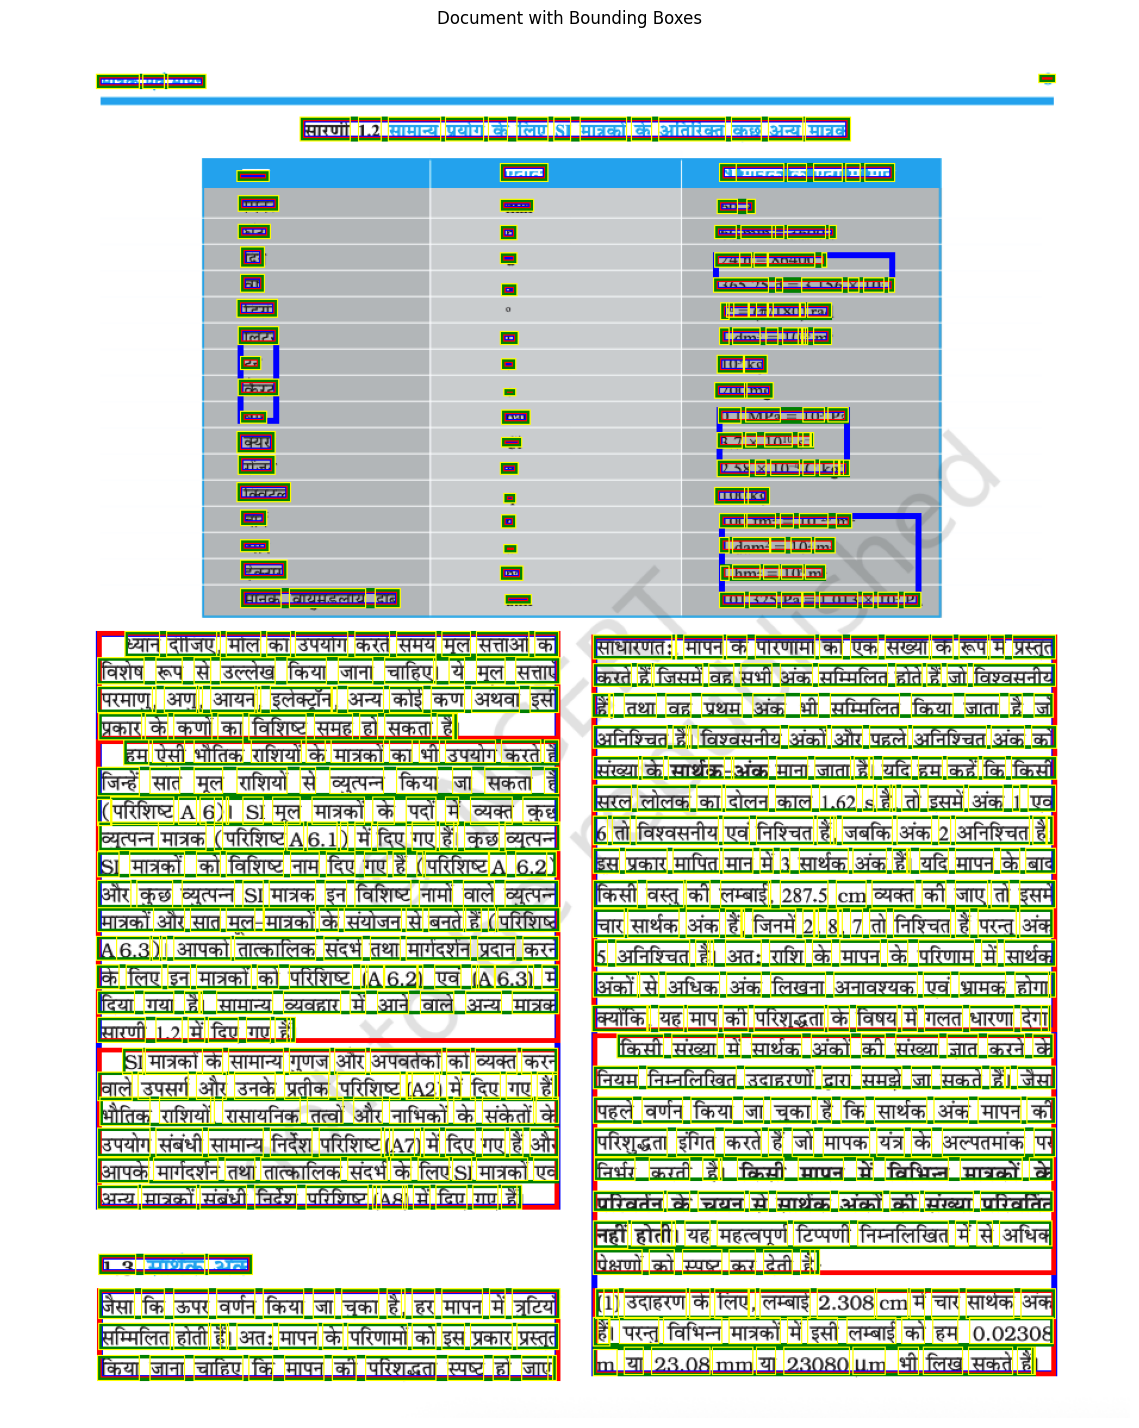

In [77]:
output_image = visualize_document_hierarchy(file_path, document)
print("Displaying the image with bounding boxes...")
plt.figure(figsize=(18, 18))
plt.imshow(output_image)
plt.title("Document with Bounding Boxes")
plt.axis("off")
plt.show()

In [84]:
output_image, shown_levels = visualize_document_hierarchy(
    file_path, 
    document, 
    levels_to_show=['block', 'paragraph'])

Visualizing hierarchy for levels: block, paragraph


Displaying the image with selected bounding boxes...


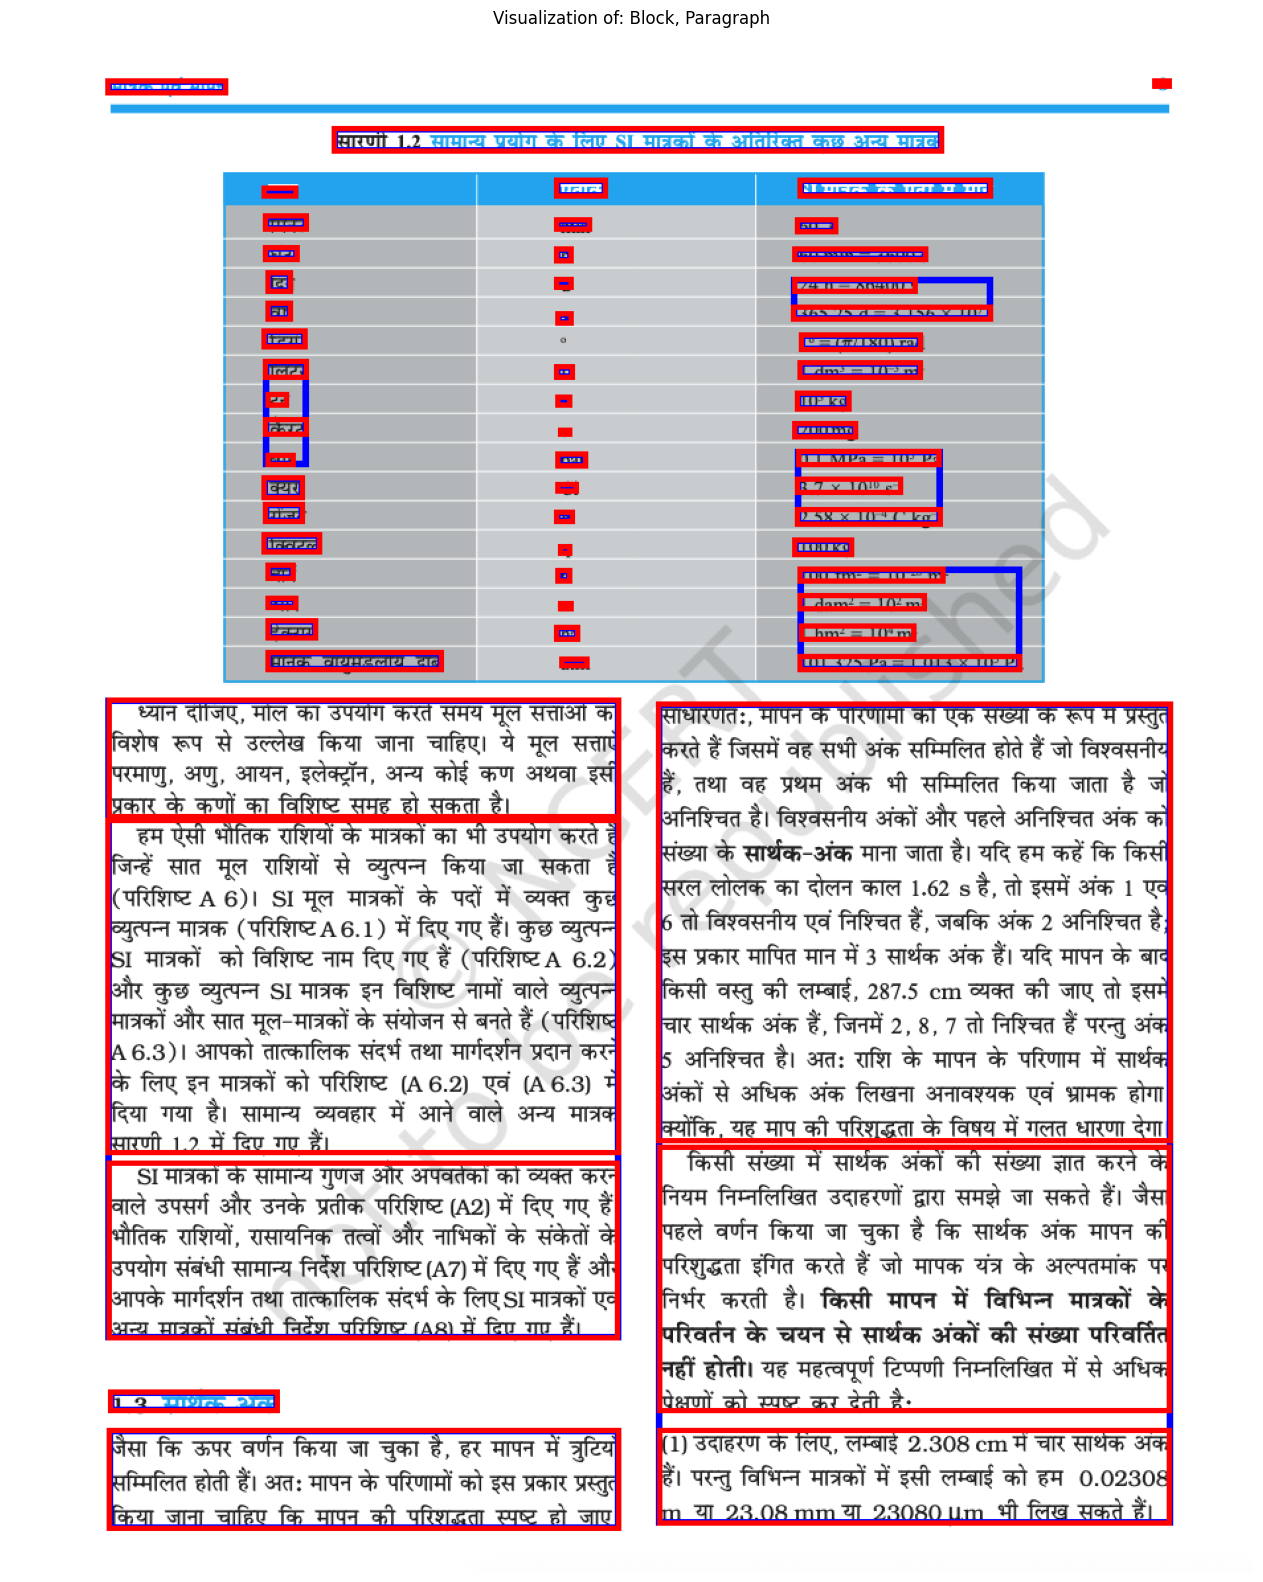

In [85]:
print("Displaying the image with selected bounding boxes...")
plt.figure(figsize=(20, 20))
plt.imshow(output_image)
# Create a dynamic title based on what was shown
title = f"Visualization of: {', '.join(s.title() for s in shown_levels)}"
plt.title(title)
plt.axis("off")
plt.show()